In [ ]:
from INFPHY201 import *

# Lecture 6: Quantum Machine Learning
 (2020) 

Welcome to Lecture 6!<br>
After this lecture you will be able to
1. Explain what differentiation really is
2. Describe the Gradient Descent algorithm
3. Apply Automatic Differentiation to turn a numpy simulation into an optimization

---
***Preview of Lecture 6:***
_Quantum Machine Learning can mean two things: either ML algorithms that run fully or in part on quantum hardware, or ML techniques applied to optimize or design quantum hardware/simulations/systems. Today we are going to look at the second: we will use Automatic Differentiation to optimize some properties of our quantum systems. AD is a very versatile meta-algorithm which we can use to turn simulations into optimizations. Although we will apply it in the context of Quantum Mechanics, it has innumerable applications._

---

# 1. Derivatives and Optimization

Before we look into Automatic Differentiation (AD), we need to first understand why differentiation is useful for optimization. The idea is that differentiation gives us the ability to move the parameters of the simulation in the correct direction to increase or decrease the output of a given cost function. In order to apply differentiation to an algorithm, we need to know how to apply the __chain rule__ and to understand the computational types that are involved in differentiating functions and algorithms.

## 1.1 The chain rule
When we have concatenated functions such as $h(g(f(x))) = r$ and we want to compute the derivative of $r$ with respect to $x$, we need the chain rule. This rule can be visualized by imagining that the functions implement some sort of algorithm, and therefore that there is a of "data" through the functions: 

$$
x \xrightarrow{f} y \xrightarrow{g} z \xrightarrow{h} r
$$

The rule then says that if we want to write the derivative of $r$ with respect to $x$, we need to go backwards, through all of the the intermediate steps between $r$ and $x$:

$$
\frac{\partial r}{\partial x} = \frac{\partial r}{\partial z}\frac{\partial z}{\partial y}\frac{\partial y}{\partial x}
$$

If we have functions of multiple variables, we just sum over all the paths that take us from $r$ to $x$: for instance, if we have $h(y, z) = r$ where $y=f(x)$ and $z=g(x)$, then we have two paths:

$\require{AMScd}$
\begin{CD}
x @>f>> y\\
@VVgV        @VVhV\\
z @>h>> r
\end{CD}

and so in order to backpropagate the derivative of $r$ all the way to $x$ we must follow both branches:

$$
\frac{\partial r}{\partial x} = \frac{\partial r}{\partial z}\frac{\partial z}{\partial x} + \frac{\partial r}{\partial y}\frac{\partial y}{\partial x}
$$



#### Activiy 1: product rule (10 minutes)
Use the chain rule to prove $\frac{\partial}{\partial x}f(x)g(x) = f'(x)g(x) + f(x)g'(x)$

## 1.2 Types
In this section we will indicate the process of differentiation by $D$, so that we avoid specifying the name of the variables. Just remember that $D$ differentiates a function with respect to all of its inputs.

We gain a huge insight on differentiation by considering the _types_ that are involved. Recall that the type of a function that maps a type $a$ to a type $b$ is $(a\rightarrow b)$. Then, we can make the following argument.
If we have a function $f$ of type $(a\rightarrow b)$, the expression $D f$ represents a new function that takes a value $x\in a$ (in the domain of $f$) and it returns the _linear approximation_ of $f$ around $x$, which is also a function from $a$ to $b$, and it has type $(a \multimap b)$ (the symbol $\multimap$ is like an arrow, but it specifies that the function is linear). Therefore $D f$ has type $(a\rightarrow (a\multimap b))$ which means that $D$ has type:

$$
D: (a\rightarrow b) \rightarrow (a\rightarrow(a\multimap b))
$$

Take a few minutes to stare at the type of $D$ and let it sink in. This is what differentiation is. 
It takes a function $f$ and it gives us a new function $f'$, which takes a a point $x$ in the domain of $f$ and it returns the linear approximation of $f$ around $x$.

Let's see an example. Let's take a function $f$ from a vector space $a$ of dimension $n$ to $\mathbb{R}$. Then $Df$ is a function of type $(a\rightarrow (a\multimap \mathbb{R}))$, so if we evaluate $Df(x)$ where $x\in a$ we obtain a linear function that maps from $a$ to $\mathbb{R}$, which approximates what $f$ would have done on inputs around $x$. But what is a linear function that maps from a vector space $a$ to $\mathbb{R}$? It's a $1\times n$ matrix. This is what we normally intend when we talk about the gradient vector: we say it's a vector (which is fine), but we often forget that it is actually a linear map. This is especially true when $a$ is $\mathbb{R}$: in that case we say that $Df(x)$ is a number (which we also write as $f'(x)$), but it is actually the linear function that multiplies by that number.

#### Activity 2: playing with types (10 minutes)
Compute the type of $D^2$, i.e. of the double differentiation. Does it now make sense that the Hessian of a function from $\mathbb{R}^n$ to $\mathbb{R}$ is a matrix of shape $n\times n$?

## 1.3 Gradient Descent

The gradient of a function $f$ of type $(a\rightarrow \mathbb{R})$ has a very precise geometrical interpretation: it's the vector in the domain that points in the direction of steepest ascent, i.e. if the inputs move in that direction the output of $f$ increases the quickest (not forever, it increases at least for a small step, or mathematically speaking for an infinitesimal step). This implies that if we move in the opposite direction, the output of $f$ decreases. This is how we maximize or minimize functions using Gradient Descent: we follow the gradient or the opposite of the gradient in small steps.

Let's say we want to minimize the value of a function $f$ of type $(a\rightarrow \mathbb{R})$. We start by evaluating $f$ at some point $x\in a$ and we obtain a value $f(x)$. If we then evaluate the gradient of $f$ at $x$, we obtain a vector $f'(x)$ (actually, we obtain the linear approximation of $f$ at $x$, expressed as a $1\times n$ matrix, but we said that it's okay to think of it as a vector). Then if $\epsilon$ is small enough, it holds that

$$f(x - \epsilon f'(x)) < f(x) < f(x + \epsilon f'(x))$$

If our goal is minimization, we update $x$ by subtracting $\epsilon f'(x)$. If our goal is maximization we update $x$ by summing $\epsilon f'(x)$. Each of these updates is one step of the Gradient Descent/Ascent algorithm. We now just have to keep repeating the process and we will eventually end up in a local minimum.

So in summary, this is the Gradient Descent algorithm:
1. $\epsilon \leftarrow \text{learning rate}$ 
2. $x \leftarrow \text{initialize x}$
3. Repeat until you're happy: $x \leftarrow (x - \epsilon f'(x)$)

Note that there exist algorithms that implement more sophisticated updates. Some of these remember the direction of previous updates and use those values to give the search some "momentum", others adapt the value of the learning rate $\epsilon$ from step to step, and so on. One of the most famous algorithms for gradient descent is [Adam](https://arxiv.org/abs/1412.6980). However, they are all variations on the most important rule: that the gradient is the direction of steepest ascent.

#### Activity 3: hardcoded Gradient Descent (15 minutes)
Consider the function $f(x) = (x-3)^2$. Compute its derivative by hand, and code a function to implement it. Then use it in a `for` loop with 1000 steps to find the minimum of $f$ via Gradient Descent. Initialize $x = 0.0$ and use a learning rate $\epsilon = 0.01$.

## 2 Automatic Differentiation

### 2.1 What does Automatic Differentiation do?
AD is a meta-algorithm. It takes an algorithm and it produces a new one for you:

$$
AD(\mathrm{algo}_\mathrm{in}) = \mathrm{algo}_\mathrm{out}
$$

If the input algorithm had type $(a\rightarrow b)$ where $a$ and $b$ are vector spaces of dimension $m$ and $n$, the output algorithm has type $(a\rightarrow (a\multimap b))$. You guessed it: the algorithm returned by AD is the derivative of the input algorithm. What this means is that if we evaluate $\mathrm{algo}_\mathrm{out}$ on an input $x\in a$, it must return a linear map from $a$ to $b$, i.e. a matrix of shape $n\times m$. As we said earlier, this map is the linear approximation of $\mathrm{algo}_\mathrm{in}$ around $x$ and it can be used for optimization.

### 2.2 Using AD for optimization
AD is implemented in several libraries: Tensorflow (since version 2) and Pytorch are the two most well-known from the world of Machine Learning and AI. Autograd and Jax are other possibilities. We will be using Jax, which is an AD library develped by Google. It makes it easy to apply AD to your projects because it has a module that can simply replace `numpy` and everything should work out of the box. Also, jax can run on GPUs and TPUs natively, so if you have one of those all the better!

If you are on colab, jax is already available to import. If you are working locally, you'll need to install it by following the instructions on [the Github page of the project](https://github.com/google/jax).

Here's how we would have used it on the problem in Activity 3:

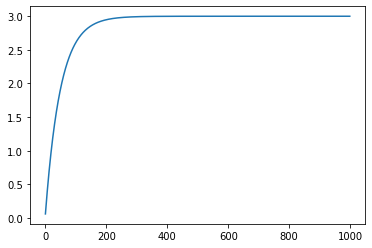

In [20]:
from jax import numpy as np # from now on, np is not numpy, but jax.numpy
from jax import grad, jit
from matplotlib import pyplot as plt

def f(x):
    return (x-3.0)**2

f_prime = grad(f) # use jit(grad(f)) if you want the faster, compiled version of grad(f)

x_values = []
e = 0.01
x = 0.0
for step in range(1000):
    x -= e*f_prime(x)
    x_values.append(x)
    
plt.plot(x_values);

#### Activity 4: apply AD to a more complex example (30 minutes)
Suppose you have been given a bunch of data points $(x_i, y_i)$ and you want to fit a line $y = mx + b$ through them. This is a perfect application of Gradient Descent!

Use this function to generate $N$ points (say, $N=20$):
```python
from numpy.random import normal as noise
def points(N):
    m = 2
    b = -4
    return [(x, m*x + b + 3*noise()) for x in range(N)]
```

1. code a cost function $C(m,b)=\frac{1}{N}\sum_i (y_i - m x_i - b)^2$
2. use jax to get the gradient of $C$ with respect to $m$ and $b$ (use `argnums=[0,1]` to get the gradient with respect to both $m$ and $b$)
3. use GD to find the optimal $m$ and $b$

## 3 Complex derivatives

We now need to understand complex derivatives, because quantum simulations involve complex numbers. In the past, it took me a bit to fully grasp it because I could not find a good resource on it. Until I encountered these [technical notes](https://mediatum.ub.tum.de/doc/631019/631019.pdf) and [this recent paper](https://arxiv.org/abs/2003.04295). If you're interested you can find more information there.

### 3.1 Derivatives of non-holomorphic functions
When we want to define derivatives of complex functions, we need to distinguish between holomorphic and non-holomorphic functions. Holomorphic functions are the nice ones, for which the method of finite differences works. However, we have to consider functions of type $(\mathbb{C}\rightarrow \mathbb{R})$, i.e. that output a real number (otherwise we cannot define an optimization) and by the Cauchy-Riemann equations, a real-valued holomorphic function must be constant! This means that if we want to define cost functions from $\mathbb{C}$ to $\mathbb{R}$ that are not boring, they must be non-holomorphic. As a rule of thumb, functions that involve the _conjugate_ of a complex variable are non-holomorphic.

Fortunately, the rule to differentiate non-holomorphic functions is simple: instead of considering a function $f:\mathbb{C}\rightarrow \mathbb{R}$ as being a function of a single complex variable $z$, we consider it a function of $z$ and $z^*$ _independently_. This means that when we compute derivatives, we will differentiate with respect to $z$ and $z^*$ as if they were independent variables. For example, the function $f(z) = |z|^2$ can be rewritten as $f(z,z^*) = zz^*$, and therefore 

$$
\begin{align}
\frac{\partial f}{\partial z} &= z^*\\
\frac{\partial f}{\partial z^*} &= z
\end{align}
$$

Now imagine that we have an algorithm which computes the function $f$ on a real variable $x$, followed by a real cost function $C$, so that $\mathbb{R} \xrightarrow{f} \mathbb{C} \xrightarrow{g} \mathbb{R}$. This process has a real input $x$ and a real output $r$, but in the middle there is a complex variable $z = f(x)$. To compute the gradient of $r$ with respect to $x$, we just apply the rule that we have just learned: 

$$
\frac{\partial r}{\partial x} = \frac{\partial r}{\partial z}\frac{\partial z}{\partial x} + \frac{\partial r}{\partial z^*}\frac{\partial z^*}{\partial x}
$$

i.e. we have treated $C(z)$ as a function of $z$ and $z^*$ as if they were independent variables, i.e. as if the cost function were $C(z,z^*)$. This gives us the correct value of the gradient in any situation.

Note that there are other techniques to differentiate non-holomorphic functions, such as writing their real and imaginary parts as two separate functions of the real and imaginary parts of the variable. I find that considering $z$ and $z^*$ as independent variables is simply more elegant, but it's possible that at times other methods may be more convenient.

### 3.2 Gradient descent for complex variables
Notice that in the previous example we were optimizing over a real domain ($x$ was real). Sometimes we need to optimize on a complex domain, i.e. if the algorithm has type $\mathbb{C}\xrightarrow{f}\mathbb{C}\xrightarrow{C}\mathbb{R}$. Let's call the input $\xi$ and the output $r$. In this case in the update rule we need the gradient with respect to the _conjugate_ of $\xi$:

$$
\xi\leftarrow \xi - \epsilon\frac{\partial r}{\partial \xi^*}
$$

It's obvious that this rule falls back to the usual update rule in case $\xi$ is real, so it's not a different rule, it's just more general (see the [technical notes](https://mediatum.ub.tum.de/doc/631019/631019.pdf) for a proof). 

As $C$ is non-holomorphic, the gradient for the update of $\xi$ is:

$$
\frac{\partial r}{\partial \xi^*} = \frac{\partial r}{\partial z}\frac{\partial z}{\partial \xi^*} + \frac{\partial r}{\partial z^*}\frac{\partial z^*}{\partial \xi^*}
$$

### 3.3 Gradient descent for vectorial functions
Now, suppose that we have an algorithm that creates a complex vector from a complex parameter and then we apply a cost function to this vector (this situation might be very common when we have an algorithm which produces a quantum state of dimension $n$, which we want to evaluate). The type of this process is $\mathbb{C} \xrightarrow{f} \mathbb{C}^n \xrightarrow{C} \mathbb{R}$ and we call the input $\xi\in\mathbb{C}$, the output $r\in\mathbb{R}$ and the complex vector $z\in\mathbb{C}^n$. How do we compute the gradient of $r$ with respect to $\xi$? Here we have to apply the principle that every component of the vector $z$ defines a different path for the chain rule and therefore we have to sum over all $n$ paths, while remembering that $C$ is non-holomorphic:

$$
\frac{\partial r}{\partial \xi^*} = \sum_{i=1}^n \left(\frac{\partial r}{\partial z_i}\frac{\partial z_i}{\partial \xi^*} + \frac{\partial r}{\partial z_i^*}\frac{\partial z_i^*}{\partial \xi^*}\right)
$$

If the algorithm had type $\mathbb{C}^m \xrightarrow{f} \mathbb{C}^n \xrightarrow{C} \mathbb{R}$, it would mean that $\xi$ is a vector. Then the gradient for the GD updates would be a vector of the same shape, whose components are:

$$
\frac{\partial r}{\partial \xi_j^*} = \sum_{i=1}^n \left(\frac{\partial r}{\partial z_i}\frac{\partial z_i}{\partial \xi_j^*} + \frac{\partial r}{\partial z_i^*}\frac{\partial z_i^*}{\partial \xi_j^*}\right)
$$

This is very common, because it includes the case where the algorithm depends on many inputs that we want to optimize at the same time. Finally, note that this case covers also the case where $\xi$ and $z$ are more generic tensors: you just have to sum over all the indices of $z$ and write the gradient of all the components of $\xi$.

#### Activity 5 (guided): optimizing a qubit state

Let's now consider a qubit state, which we parametrize using two complex amplitudes.

We want to find the ground state of a Hamiltonian $H$, i.e. the state of the qubit that minimizes the expectation value.

$$
|\psi_0\rangle = \mathrm{argmin}_{|\psi\rangle \in \mathcal{H}} \langle\psi|H|\psi\rangle
$$

As a hamiltonian we will choose the Pauli matrix $\sigma_x$. We already know that $\sigma_x$ has two eigenvalues $\pm1$, and that the eigenstate relative to the eigenvalue -1 is $|-\rangle = (|0\rangle-|1\rangle)/\sqrt{2}$, so we expect the optimization to drive any initial random state to $|-\rangle$.

Let's start by defining the cost function:

In [4]:
H = np.array([[0.0, 1.0], [1.0, 0.0]])

def C(psi):
    return np.real(np.matmul(np.conj(psi), np.matmul(H, psi))) + 10*(np.linalg.norm(psi) - 1.0)**2

Notice a few things:
1. We used `np.real` so that the type of the output of the cost function is a real number, as it should be. Even if mathematically $\langle\psi|H|\psi\rangle$ is a real number because $H$ is Hermitian, python and jax don't know that.
2. We added a piece to the cost function! The piece is $(\langle\psi|\psi\rangle - 1)^2$, which mathematically should always be zero, because $|\psi\rangle$ is normalized and so $\langle\psi|\psi\rangle = 1$. However, jax doens't know that $|\psi\rangle$ should have norm 1, so the cost must increase when the norm of $|\psi\rangle$ deviates from 1.

In [5]:
from jax import jacobian
jac = jit(jacobian(C))

We are using `jacobian` instead of `grad` because it returns a nice vector, instead of a tuple of values. This is especially useful when the set of values that we want to optimize is an actual vector rather than a bunch of unrelated variables (like $m$ and $b$ in Activity 4).

In [12]:
from INFPHY201 import random_state

psi = random_state(2)
e = 0.001
path = []
for step in range(2000):
    psi -= e*np.conj(jac(psi))
    if step%100 == 0:
        path.append(psi)


Now we plot a few of the states that were generated during the GD procedure. To do this in a clean way, we need to supply a numpy array to `Qobj`, but we have `DeviceArray` objects (the arrays of jax). Fortunately, they implement a "dunder" method `__array__()` that returns a numpy array.

In [13]:
from qutip import Bloch, Qobj
sphere = Bloch()

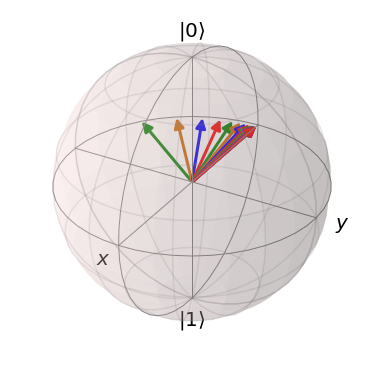

In [14]:
sphere.clear()
sphere.add_states([Qobj(psi.__array__()).unit() for psi in path])

sphere.show()

# 4. Conclusion

Today we have seen how to properly define differentiation and how to extend it to complex functions, and in particular non-holomorphic functions, which appear naturally when we simulate quantum mechanical systems and interactions.

We have seen how to use AD to differentiate _code_! We have then used it to turn a simulation (a computation of the expectation value of a Pauli operator) into an optimization.

My hope is that these techniques will stay with you beyond INFPHY201.